<a href="https://colab.research.google.com/github/arcweld/DSI_Capstone_2/blob/main/Capstone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance
This notebook explores the database created by NASA as the Turbofan Engine Degradation Simulation Data Set

# Imports

In [ ]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
import itertools

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score


# Modules and Helper Functions

In [ ]:
DOWNLOAD_ROOT = 'https://ti.arc.nasa.gov/'
ENG_PATH = os.path.join('data','nasa_eng')
ENG_URL = DOWNLOAD_ROOT + 'c/6' 

def fetch_eng_data(eng_url=ENG_URL, eng_path=ENG_PATH):
    os.makedirs(eng_path, exist_ok=True)
    if not os.path.exists(os.path.join(eng_path,'CMAPSSData.zip')):
        zip_path = os.path.join(eng_path, 'CMAPSSData.zip')
        urllib.request.urlretrieve(eng_url, zip_path)
        eng_zip = zipfile.ZipFile(zip_path, 'r')
        eng_zip.extractall(path=eng_path)
        eng_zip.close()
        print('All files downloaded and extracted')
    else:
        print('All files in place')
        
    
def load_train_data(series_n=1):
    new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
    df = pd.read_csv(f'data/nasa_eng/train_FD00{series_n}.txt', sep=' ', names=new_col)
    df.drop(['x1', 'x2'], axis=1, inplace=True)
    return df

    
def load_test_data(series_n=1):
    new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
    df = pd.read_csv(f'data/nasa_eng/test_FD00{series_n}.txt', sep=' ', names=new_col, header=None)
    df.drop(['x1', 'x2'], axis=1, inplace=True)
    truth = pd.read_csv(f'data/nasa_eng/RUL_FD00{series_n}.txt', header=None, names=['eol'])
    truth['id'] = truth.index +1
    df = df.merge(truth, on=['id'], how='left')
    return df

def normalize_data(df1, *df2):
    scale = MinMaxScaler()
    scale.fit(df1.loc[:,'s1':'s21'])
    scale.transform(df1.loc[:,'s1':'s21'])
    if df2:
        scale.transform(df2.loc[:,'s1':'s21'])
        return df1, df2
    return df1

def add_labels(df):
    if 'eol' not in df.columns:
        fail = df.groupby('id').cycle.max()
        df['eol'] = df['id'].apply(lambda x: fail[x])

    df['RUL'] = df['eol'] - df['cycle']
    df.drop('eol', axis=1, inplace=True)
    df['f30'] = df['RUL'].apply(lambda x: 2 if x <= 10 else 1 if x <=30 else 0)
    df['f10'] = df['RUL'].apply(lambda x: 1 if x <= 10 else 0)

    return df

def window_avg_sd(df, win=5):
    win = 5
    sensor = {f's{i}': [f'a{i}', f'sd{i}'] for i in range(1,22) }
    if 'a1' in df.columns: 
        print('DF previously transformed')
        return None
    for s, agg in sensor.items():
        for id in df.id.unique():
            avg = df[s].groupby(df['id']).rolling(window=win, min_periods=4).mean()
            sd = df[s].groupby(df['id']).rolling(window=win, min_periods=4).std()
        df.insert(len(df.columns)-4, f'{agg[0]}', avg.values)
        df.insert(len(df.columns)-4, f'{agg[1]}', sd.values)
    
    return df

# Tensorflow functions

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]



# Load Data

In [ ]:
fetch_eng_data()

All files in place


In [ ]:
seq_cols = ["cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

In [ ]:
df1 = load_train_data(1)
df_test = load_test_data(1)

df1 = add_labels(df1)
df_test = add_labels(df_test)



# Exploratory Data Analysis and Visualisation

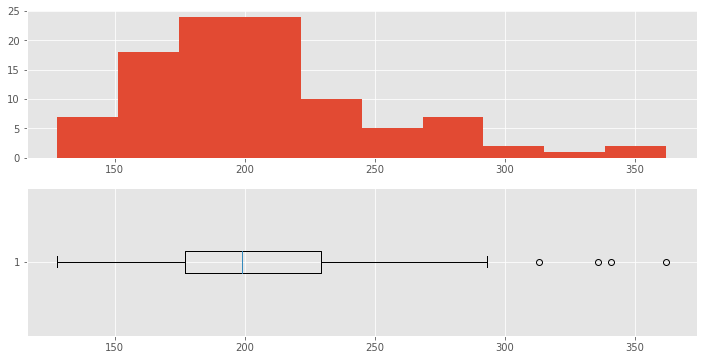

In [ ]:
train1_fail = df1.groupby('id').cycle.max()

fig, axs = plt.subplots(2, figsize=(12,6))
axs[0].hist(train1_fail)
axs[1].boxplot(train1_fail, vert=False);

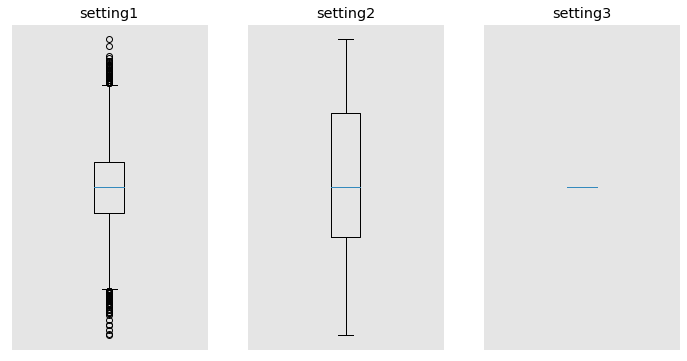

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12,6))
for i in range(3):
    axs[i].boxplot(df1.iloc[:,i+2])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'setting{i+1}')

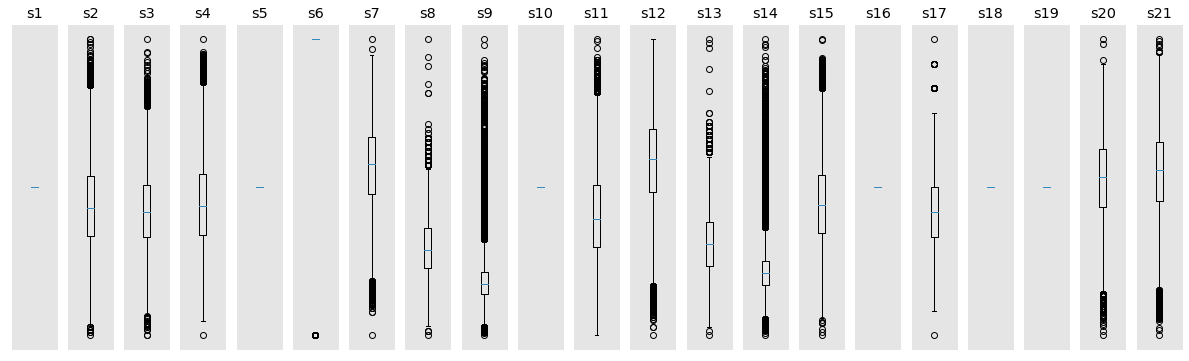

In [ ]:
fig, axs = plt.subplots(1,21, figsize=(21,6))
for i in range(21):
    axs[i].boxplot(df1.iloc[:,i+5])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'{df1.columns[i+5]}')

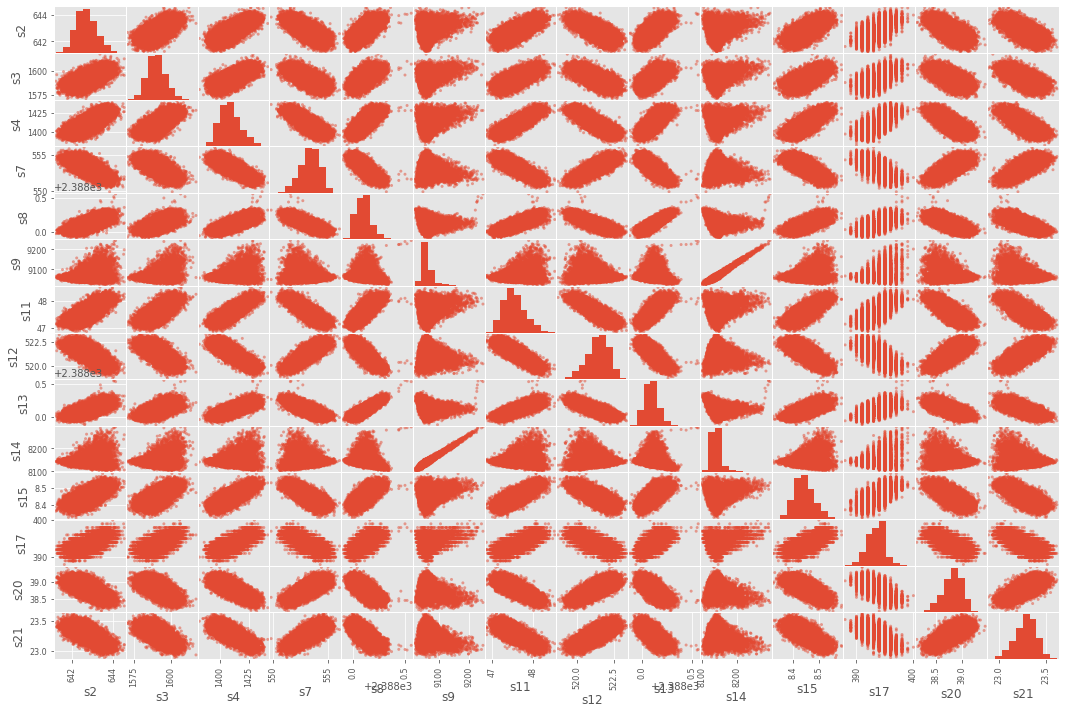

In [ ]:
scatter_matrix(df1.iloc[:,np.r_[6,7,8,11,12,13,15,16,17,18,19,21,24,25]], figsize=(18,12));

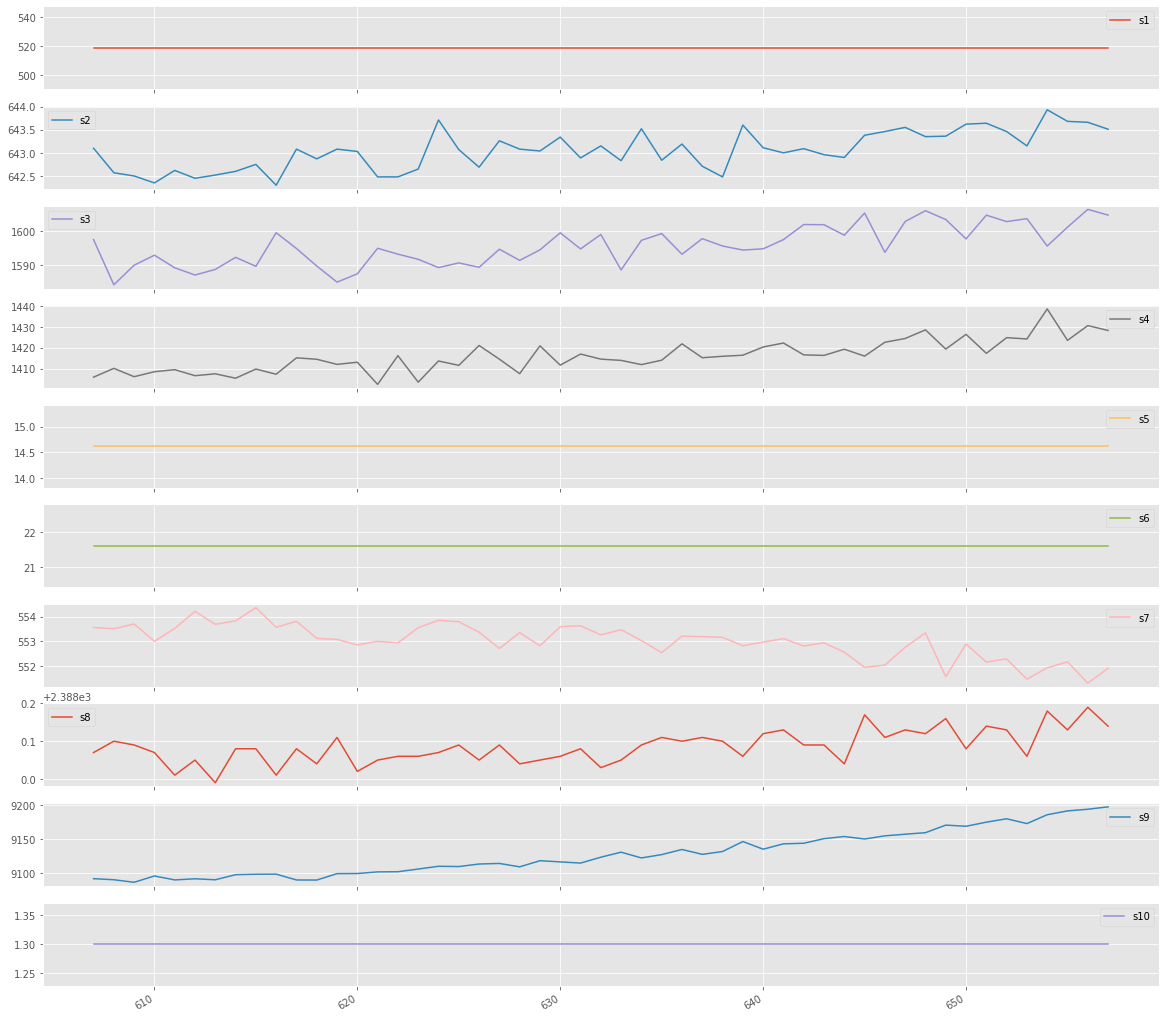

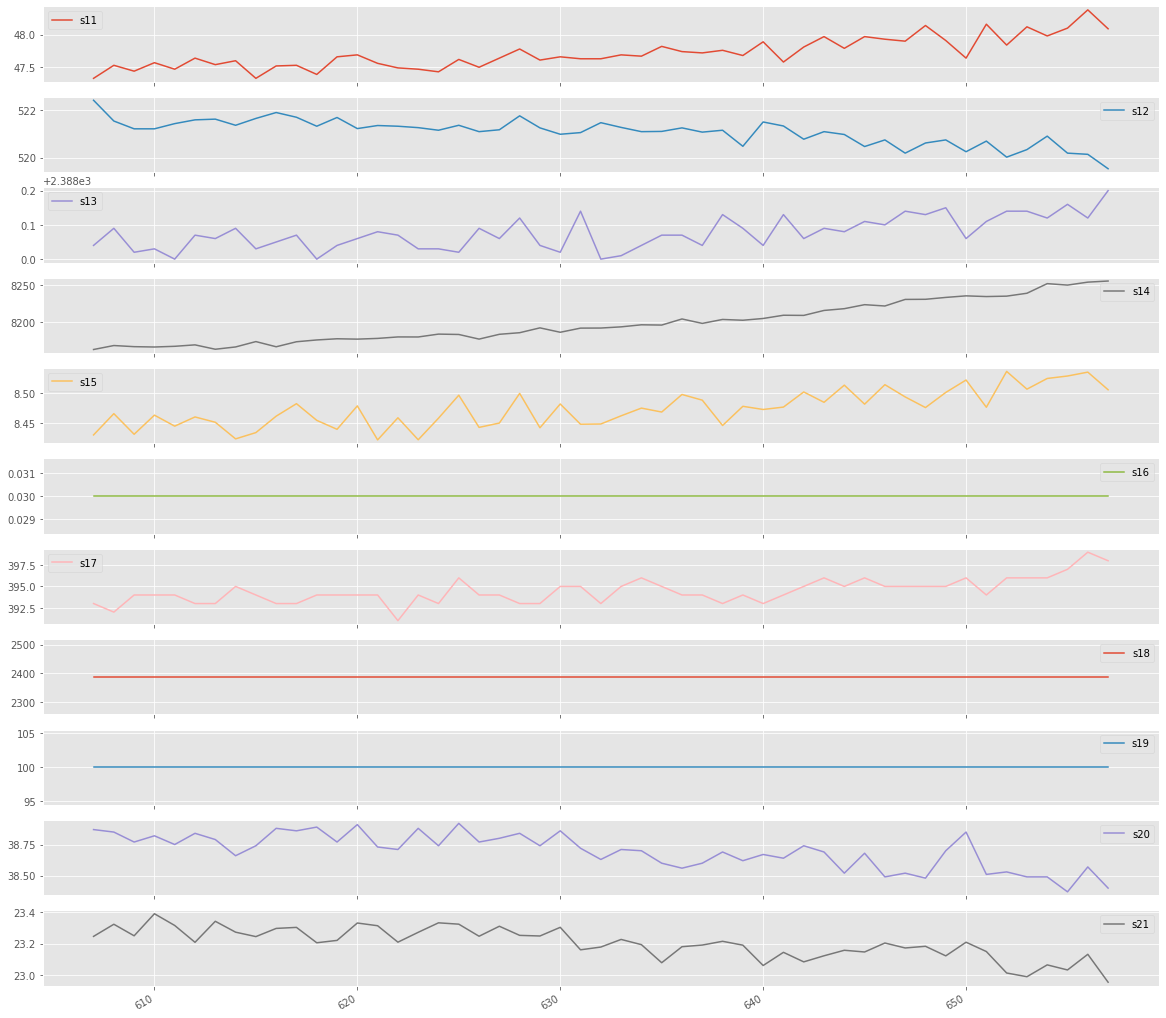

In [ ]:
engine_id3 = df1[df1['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 . For now Databricks did not support pandas.plot()
engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20));

In [ ]:
window_avg_sd(df1)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,a1,sd1,a2,sd2,a3,sd3,a4,sd4,a5,sd5,a6,sd6,a7,sd7,a8,sd8,a9,sd9,a10,sd10,a11,sd11,a12,sd12,a13,sd13,a14,sd14,a15,sd15,a16,sd16,a17,sd17,a18,sd18,a19,sd19,a20,sd20,a21,sd21,s21,RUL,f30,f10
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,518.67,0.0,642.1675,0.250117,1588.075,3.855909,1402.4525,1.559645,14.62,0.0,21.61,0.000000e+00,554.205,0.313103,2388.0725,0.029861,9048.170,3.881555,1.3,0.0,47.340,0.171659,522.305,0.495950,2388.050,0.029439,8134.2925,3.050906,8.409325,0.028117,0.03,0.0,391.5,1.000000,2388.0,0.0,100.0,0.0,38.9725,0.076322,23.390175,0.037977,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,518.67,0.0,642.2080,0.234776,1587.030,4.075678,1403.2060,2.159440,14.62,0.0,21.61,0.000000e+00,554.164,0.286234,2388.0700,0.026458,9049.566,4.587366,1.3,0.0,47.328,0.151063,522.282,0.432574,2388.048,0.025884,8134.1940,2.651326,8.413340,0.025953,0.03,0.0,391.8,1.095445,2388.0,0.0,100.0,0.0,38.9580,0.073621,23.393020,0.033498,23.4044,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,518.67,0.0,643.4480,0.230261,1599.270,1.605506,1427.2700,4.656871,14.62,0.0,21.61,6.228568e-08,551.604,0.393230,2388.2220,0.046043,9066.416,3.686839,1.3,0.0,48.156,0.060249,519.890,0.460000,2388.232,0.037014,8141.1300,2.446753,8.520120,0.027684,0.03,0.0,395.8,1.643168,2388.0,0.0,100.0,0.0,38.4080,0.163003,23.079640,0.086540,22.9735,4,2,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,518.67,0.0,643.4500,0.231193,1599.924,2.814397,1430.0900,2.555181,14.62,0.0,21.61,6.228568e-08,551.548,0.485046,2388.2340,0.035777,9067.348,2.008761,1.3,0.0,48.128,0.076616,519.708,0.242322,2388.234,0.035777,8139.7380,2.750731,8.525060,0.022507,0.03,0.0,395.4,1.516575,2388.0,0.0,100.0,0.0,38.3560,0.142583,23.096120,0.093479,23.1594,3,2,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,518.67,0.0,643.5160,0.125817,1600.454,3.028907,1429.9400,2.660160,14.62,0.0,21.61,6.228568e-08,551.328,0.454610,2388.2240,0.019494,9067.014,2.099412,1.3,0.0,48.108,0.069065,519.688,0.201544,2388.244,0.026077,813

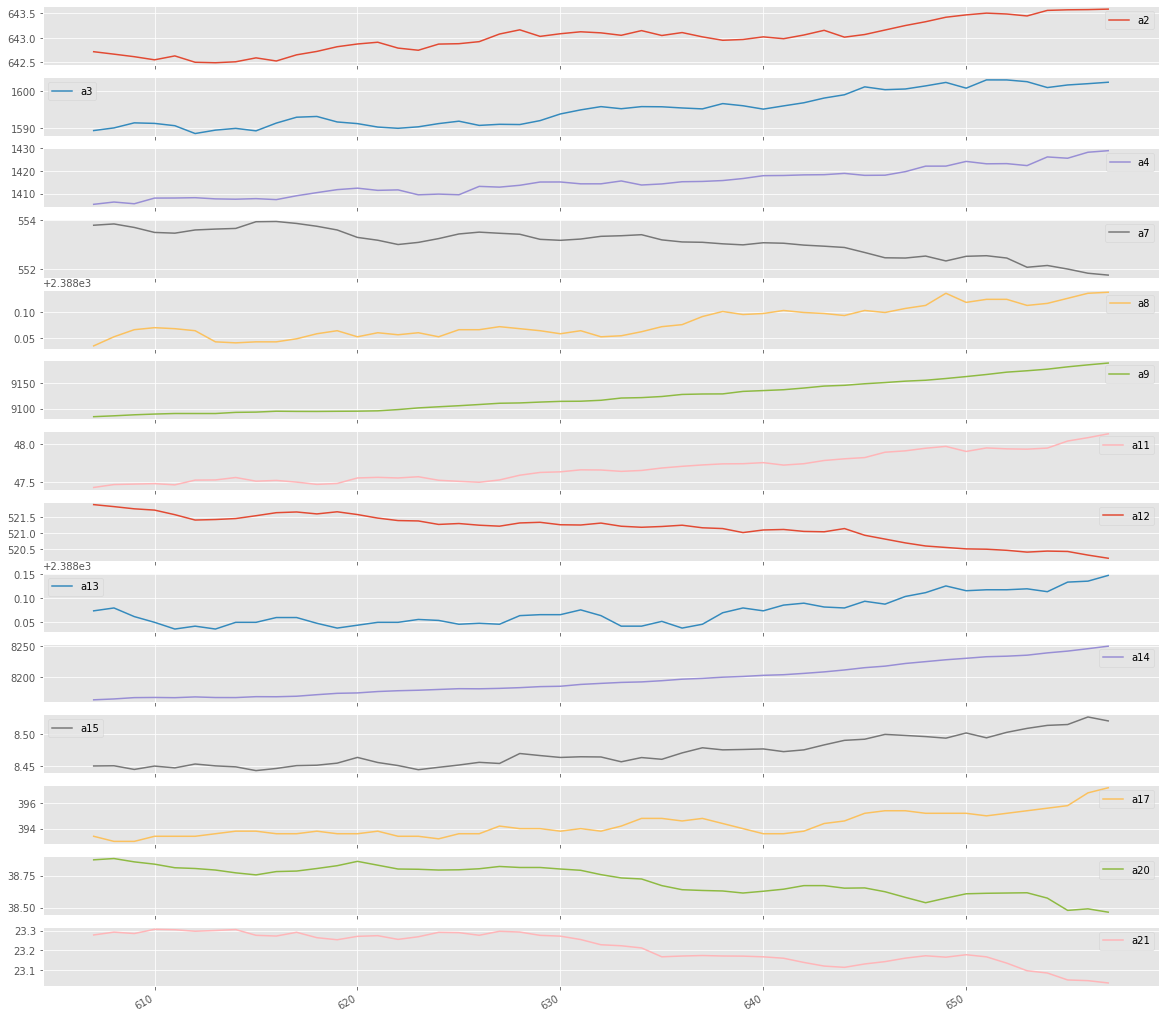

In [ ]:
engine_id3 = df1[df1['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['a2', 'a3', 'a4', 'a7', 'a8', 'a9', 'a11', 'a12', 'a13', 'a14', 'a15', 'a17', 'a20', 'a21']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]

# plotting sensor data for engine ID 3 prior to a failure point
engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20));

In [ ]:
q25 = dfc.loc[:,'Tamaki Drive, Filtered'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).quantile(0.25)
q75 = dfc.loc[:,'Tamaki Drive, Filtered'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).quantile(0.75)

In [ ]:
q25 = pd.DataFrame()
q75 = pd.DataFrame()
sensor = [f's{i}' for i in range(1,22) ]
for s in sensor:
        q25.insert(len(q25.columns), f'{s}', df1['a4'].groupby(df1['RUL']).quantile(0.25))
        q75.insert(len(q75.columns), f'{s}', df1['a4'].groupby(df1['RUL']).quantile(0.75))
q25.dropna(axis=0, inplace=True)
q75.dropna(axis=0, inplace=True)
q75

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
RUL,,,,,,,,,,,,,,,,,,,,,
0,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890,1430.0890
1,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215,1429.7215
2,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595,1428.9595
3,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040,1428.7040
4,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940,1428.1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140,1402.4140
355,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740,1402.9740
356,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780,1403.4780


In [ ]:
engine_id3 = df1[df1['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['a2', 'a3', 'a4', 'a7', 'a8', 'a9', 'a11', 'a12', 'a13', 'a14', 'a15', 'a17', 'a20', 'a21']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]

# plotting sensor data for engine ID 3 prior to a failure point
engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20));

ax.fill_between(seas_cycl.index, q25.values.ravel(), q75.values.ravel(), color='0.8')


# Build models

In [ ]:
# MODELLING.....pick a large window size of 50 cycles
seq_length = 50

(15631, 50, 25)

In [ ]:
# generator for the sequences
seq_gen = (list(gen_sequence(df1[df1['id']==id], seq_length, seq_cols)) 
           for id in df1['id'].unique())

In [ ]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

In [ ]:
# generate labels
label_gen = [gen_labels(df1[df1['id']==id], seq_length, ['f10']) 
             for id in df1['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [ ]:
# Define the LSTM network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#%%time
# Train the network
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

Epoch 1/10
79/79 [==============================] - 7s 93ms/step - loss: 0.2549 - accuracy: 0.9296
Accurracy: 0.929627001285553


In [ ]:
label_array.max()

1.0

In [ ]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array) > 0.5).astype("int32")

In [ ]:
len(y_pred)

15631

In [ ]:

y_true = label_array
y_true.ravel()

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [ ]:

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[14531,     0],
       [ 1100,     0]])

In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)


precision =  0.0 
 recall =  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# compute AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, y_pred)
print( 'auc = ', auc)

auc =  0.5
